# Implementation

In [1]:
#importing prerequisite libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
%matplotlib inline

#import data set, specify delimiter and encoding & convert to dataframe
df = pd.read_csv("Thesis/Dataset/PLT_COMBINED_CLASSIFIER.csv",sep=';',encoding='latin1')
#rename columns
df = df.rename(columns={'PRICE_DEV_QU': 'AVG_PRICE_DEV' , 'PRIMARY_PRODUCT_SALES': 'PRIMARY_PROD_SALES', 'Bezeichnung': 'EQUIPMENT', 'KNA1.Land': 'Country', 'EQUI.Kundenbranche': 'SEGMENT', 'KNA1.KEY_ACCOUNT': 'KEY_ACCOUNT', 'KNA1.Umsatzanteil_Land': 'COUNTRY_SALES_SHARE', 'Umsatzanteil_Kunde': 'CUSTOMER_SALES_SHARE', 'Angebotserfolg': 'QUOTE_CONV', 'Anzahl Angebote': 'QUOTE_COUNT', 'Land_Neu': 'COUNTRY_CLUSTERED'})
#drop columns
df.drop(['Meldung','Kundenauftrag','Kunde','Bezugsmenge', 'KNA1.Ist-Konzern','Country'], axis=1, inplace=True)
df.head()

,EQUIPMENT,QUOTE_COUNT,QUOTE_CONV,CUSTOMER_SALES_SHARE,AVG_PRICE_DEV,PRIMARY_PROD_SALES,KEY_ACCOUNT,COUNTRY_SALES_SHARE,SEGMENT,COUNTRY_CLUSTERED
0,Other,2,Success,"0,000935757",1,1,0,"0,000935757",Oilseed,Other
1,Other,1,Failure,"0,000935757",1,1,0,"0,000935757",Oilseed,Other
2,Other,1,Failure,"0,000935757",1,1,0,"0,000935757",Oilseed,Other
3,SP,2,Success,"0,000935757","0,807620664","0,774911362",0,"0,000935757",Oilseed,Other
4,SP,1,Failure,"0,000935757","1,012025831",1,0,"0,000935757",Oilseed,Other


In [2]:
#conversion decimal points and data type
df['CUSTOMER_SALES_SHARE'] = [x.replace(',', '.') for x in df['CUSTOMER_SALES_SHARE']]
df['CUSTOMER_SALES_SHARE'] = df['CUSTOMER_SALES_SHARE'].astype('float64')

df['COUNTRY_SALES_SHARE'] = [x.replace(',', '.') for x in df['COUNTRY_SALES_SHARE']]
df['COUNTRY_SALES_SHARE'] = df['COUNTRY_SALES_SHARE'].astype('float64')

df['AVG_PRICE_DEV'] = [x.replace(',', '.') for x in df['AVG_PRICE_DEV']]
df['AVG_PRICE_DEV'] = df['AVG_PRICE_DEV'].astype('float64')

df['PRIMARY_PROD_SALES'] = [x.replace(',', '.') for x in df['PRIMARY_PROD_SALES']]
df['PRIMARY_PROD_SALES'] = df['PRIMARY_PROD_SALES'].astype('float64')

In [3]:
#top n most frequent values
#df['QUOTE_CONV'].value_counts()
#df['AVG_PRICE_DEV'].nlargest(30)

## One-Hot Encoding

In [4]:
ohe = OneHotEncoder(sparse=False)
df_segment = pd.get_dummies(df['SEGMENT'])
df_country = pd.get_dummies(df['COUNTRY_CLUSTERED'])
df_equipment = pd.get_dummies(df['EQUIPMENT'])
df = pd.concat((df, df_segment, df_country, df_equipment), axis=1)

#drop features

#branche
df.drop(['SEGMENT'], axis=1, inplace=True)
df.drop(['Oilseed'], axis=1, inplace=True)
df.drop(['Rendering'], axis=1, inplace=True)

#countries
df.drop(['COUNTRY_CLUSTERED'], axis=1, inplace=True)
df.drop(['US'], axis=1, inplace=True)
df.drop(['GB'], axis=1, inplace=True)
df.drop(['FR'], axis=1, inplace=True)
df.drop(['PL'], axis=1, inplace=True)
df.drop(['RU'], axis=1, inplace=True)
df.drop(['DE'], axis=1, inplace=True)
df.drop(['Other'], axis=1, inplace=True)

#equipment
df.drop(['EQUIPMENT'], axis=1, inplace=True)
df.drop(['EP'], axis=1, inplace=True)
df.drop(['SV'], axis=1, inplace=True)
df.drop(['SP'], axis=1, inplace=True)

#combined metrics
# df.drop(['COUNTRY_SALES_SHARE'], axis=1, inplace=True)
# df.drop(['CUSTOMER_SALES_SHARE'], axis=1, inplace=True)
# df.drop(['QUOTE_COUNT'], axis=1, inplace=True)
df.drop(['KEY_ACCOUNT'], axis=1, inplace=True)
df.drop(['PRIMARY_PROD_SALES'], axis=1, inplace=True)

#display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285 entries, 0 to 5284
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   QUOTE_COUNT           5285 non-null   int64  
 1   QUOTE_CONV            5285 non-null   object 
 2   CUSTOMER_SALES_SHARE  5285 non-null   float64
 3   AVG_PRICE_DEV         5285 non-null   float64
 4   COUNTRY_SALES_SHARE   5285 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 206.6+ KB


## Extract features, detect outliers & split dataset

In [5]:
#extract features and target variables
x = df.drop(columns="QUOTE_CONV",)
y = df["QUOTE_CONV"]
#save the feature name and target variables
feature_names = x.columns
labels = np.array(['Failure', 'Success'])
before_removal = len(df.index)

In [6]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(x)
df['outlier'] = clf.negative_outlier_factor_*-1

In [7]:
df = df[df.outlier <= 2]
df.drop(['outlier'], axis=1, inplace=True)
after_removal = len(df.index)

In [8]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 42, stratify=y)
#y_train[y_train == 'Success'].count()
#y_test[y_test == 'Failure'].count()

In [9]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
QUOTE_COUNT,5201.0,1.11,0.33,1.00,1.00,1.00,1.00,3.00
CUSTOMER_SALES_SHARE,5201.0,0.01,0.01,0.00,0.00,0.01,0.02,0.04
AVG_PRICE_DEV,5201.0,1.05,0.31,0.12,0.95,1.00,1.08,5.06
COUNTRY_SALES_SHARE,5201.0,0.11,0.10,0.00,0.02,0.09,0.24,0.24


In [10]:
outlier_removed = before_removal - after_removal
print("{} examples classified as outliers and removed.".format(outlier_removed))

84 examples classified as outliers and removed.


## Fitting the model
The classifier is assigned to clf and set max_depth = n and random_state = n. The random_state parameter ensures that the results can be replicated in further analyses.
Fitting algorithm to the training data.

In [11]:
clf = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    #class_weight="balanced",
    presort='deprecated',
    ccp_alpha=0.0,
)
clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

## Visualization

In [12]:
# #import relevant packages
# from sklearn import tree
# import matplotlib.pyplot as plt
# #plt the figure
# plt.figure(figsize=(30,10), facecolor ='tab:gray')
# #create the tree plot
# a = tree.plot_tree(clf,#use the feature names stored
#                    feature_names = feature_names,
#                    #use the class names stored
#                    class_names = labels,
#                    impurity = True,
#                    node_ids = True,
#                    proportion=False,
#                    rounded = True,
#                    filled = True,
#                    precision=5,
#                    fontsize=10)
# #show the plot
# plt.show()

In [13]:
nodes_preliminary = clf.tree_.node_count
nodes_preliminary

2861

## Post pruning decision trees with cost complexity pruning

In [14]:
# determination of alpha values
path = clf.cost_complexity_pruning_path(x_train, y_train)
#extract alpha values
ccp_alphas, impurities = path.ccp_alphas, path.impurities

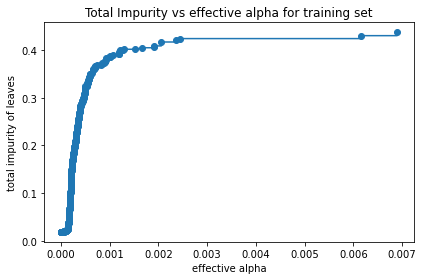

In [15]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
fig.tight_layout()
fig.savefig('Thesis/Graphics/impurity_vs_alpha.svg', format='svg', facecolor=fig.get_facecolor())

In [16]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.02284055491053516


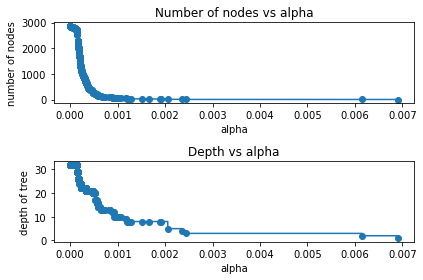

In [17]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
fig.savefig('Thesis/Graphics/number_nodes_vs_alpha.svg', format='svg', facecolor=fig.get_facecolor())

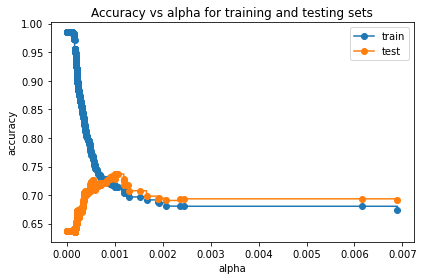

In [18]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.savefig('Thesis/Graphics/accuracy_vs_alpha.svg', format='svg', facecolor=fig.get_facecolor())
fig.tight_layout()
plt.show()

In [19]:
#cost computation pruning value that produces the highest accuracy in the test data
i = np.arange(len(ccp_alphas))
ccp = pd.DataFrame({'Depth': pd.Series(depth,index=i),'Node' : pd.Series(node_counts, index=i),\
                    'ccp' : pd.Series(ccp_alphas, index = i),'train_scores' : pd.Series(train_scores, index = i),
                   'test_scores' : pd.Series(test_scores, index = i)})
ccp.tail()
ccp[ccp['test_scores']==ccp['test_scores'].max()]

,Depth,Node,ccp,train_scores,test_scores
564,10,55,0.001009,0.714995,0.736991
565,10,53,0.001010,0.714995,0.736991
566,10,51,0.001019,0.714995,0.736991
567,10,49,0.001065,0.713813,0.736991


In [20]:
ideal_ccp_alpha = float(ccp.loc[ccp['test_scores'].idxmax(), ['ccp']])
ideal_ccp_alpha

0.0010091453800063063

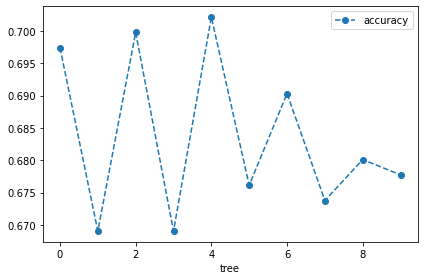

In [21]:
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10)
df_new= pd.DataFrame(data={'tree': range(10), 'accuracy': scores})
plot = df_new.plot(x='tree', y='accuracy', marker='o', linestyle='--')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig('Thesis/Graphics/crossvalidation.svg', format='svg', facecolor=fig.get_facecolor())

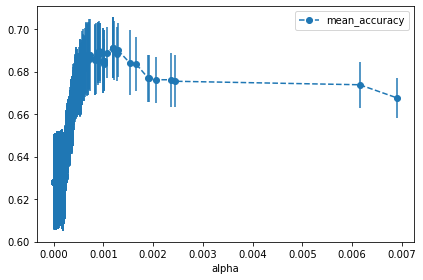

In [22]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                            columns=['alpha', 'mean_accuracy', 'std'])

plot = alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig('Thesis/Graphics/alpha_loop_values.svg', format='svg', facecolor=fig.get_facecolor())

In [23]:
optimal_ccp_alpha = float(alpha_results.loc[alpha_results['mean_accuracy'].idxmax(), ['alpha']])
optimal_ccp_alpha

0.0011825230155602315

### Pruned Tree

In [24]:
clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)
clf_pruned = clf_pruned.fit(x_train, y_train)

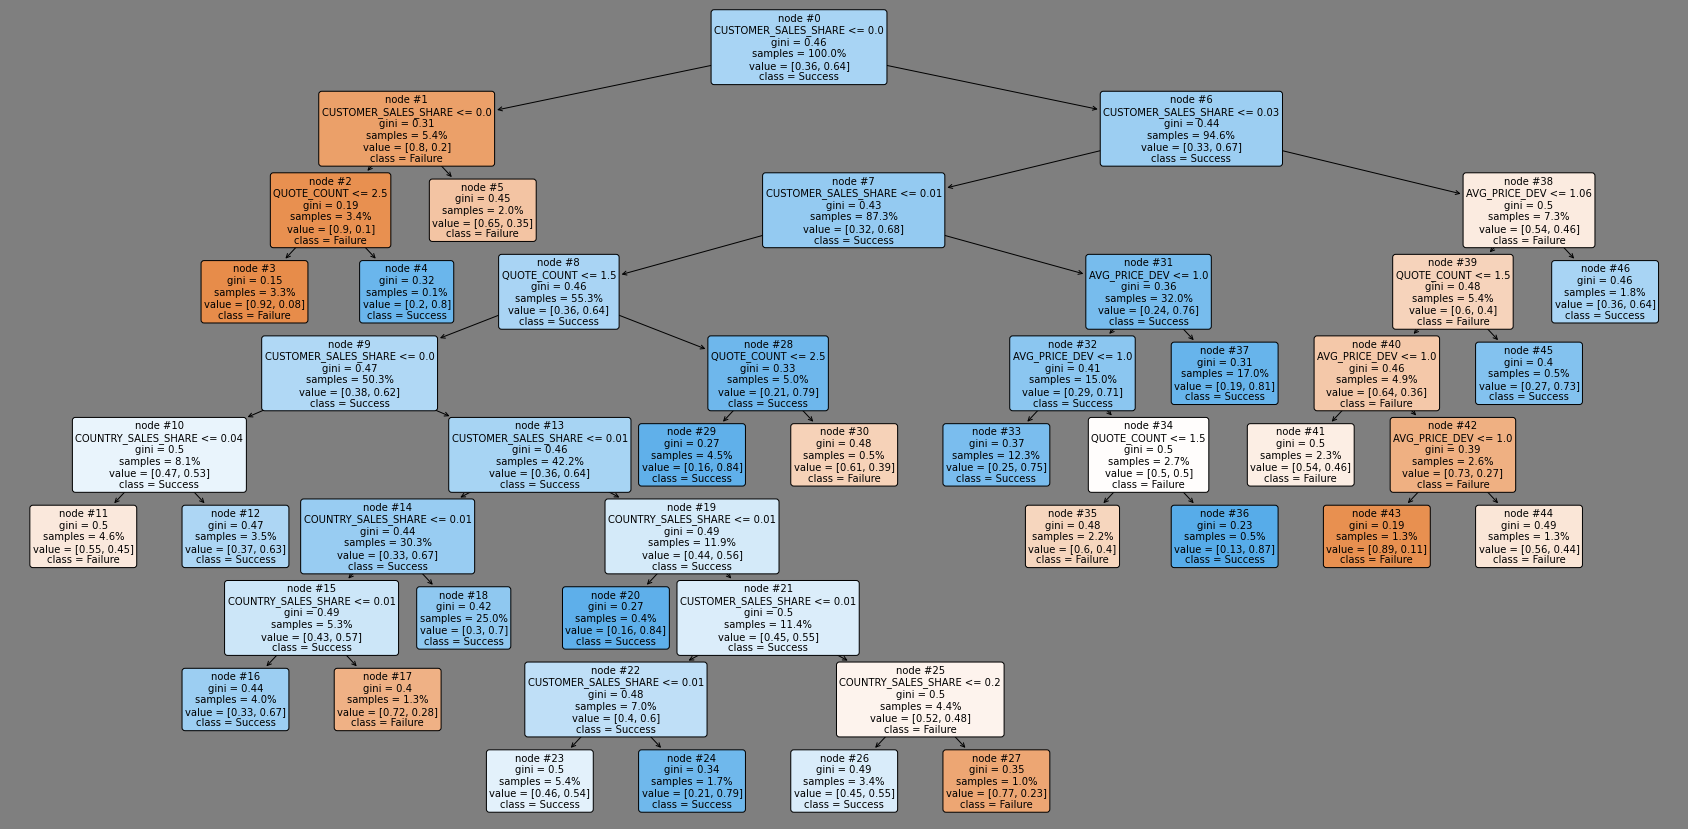

In [25]:
#plt the figure
plt.figure(figsize=(30,15), facecolor ='tab:grey')
#create the tree plot
a = tree.plot_tree(clf_pruned,#use the feature names stored
                   feature_names = feature_names,
                   #use the class names stored
                   class_names = labels,
                   impurity = True,
                   node_ids = True,
                   proportion=True,
                   rounded = True,
                   filled = True,
                   precision=2,
                   fontsize=10)
#show the plot
plt.savefig('Thesis/Graphics/pruned_tree.svg', format='svg', facecolor=fig.get_facecolor())
fig.tight_layout()
plt.show()

## Decision Tree Rules

In [26]:
n_nodes = clf_pruned.tree_.node_count
children_left = clf_pruned.tree_.children_left
children_right = clf_pruned.tree_.children_right
feature = clf_pruned.tree_.feature
threshold = clf_pruned.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # pop ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If left unequal right child of a node = split node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If split node, append left and right children and depth to `stack` to loop through
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a terminal node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 47 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 0.00013954549649497494 else to node 6.
	node=1 is a split node: go to node 2 if X[:, 1] <= 6.1499999901570845e-06 else to node 5.
		node=2 is a split node: go to node 3 if X[:, 0] <= 2.5 else to node 4.
			node=3 is a terminal node.
			node=4 is a terminal node.
		node=5 is a terminal node.
	node=6 is a split node: go to node 7 if X[:, 1] <= 0.030991055071353912 else to node 38.
		node=7 is a split node: go to node 8 if X[:, 1] <= 0.009765699040144682 else to node 31.
			node=8 is a split node: go to node 9 if X[:, 0] <= 1.5 else to node 28.
				node=9 is a split node: go to node 10 if X[:, 1] <= 0.0013718989794142544 else to node 13.
					node=10 is a split node: go to node 11 if X[:, 3] <= 0.0436039213091135 else to node 12.
						node=11 is a terminal node.
						node=12 is a terminal node.
					node=13 is a split node: go to node 14 if X[:, 1] <= 0.007327

In [27]:
#node reduction
print("The preliminary tree structure has {nodes_preliminary} nodes, while the pruned tree has {n_nodes} nodes. That equals a node reduction of {node_reduction} nodes.".format(nodes_preliminary=nodes_preliminary, n_nodes=n_nodes, node_reduction=nodes_preliminary-n_nodes))

The preliminary tree structure has 2861 nodes, while the pruned tree has 47 nodes. That equals a node reduction of 2814 nodes.


## Measuring performance

In [28]:
test_pred_decision_tree = clf_pruned.predict(x_test)

### Confusion Matrix

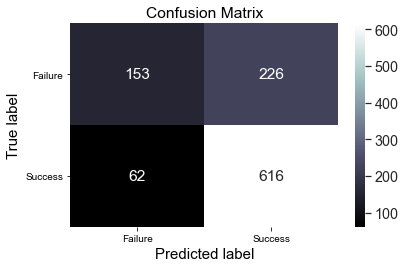

<Figure size 3600x1800 with 0 Axes>

In [29]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_decision_tree)
#turn into dataframe
matrix_df = pd.DataFrame(confusion_matrix)

FP = matrix_df.iat[0,1]
FN = matrix_df.iat[1,0]
TP = matrix_df.iat[1,1]
TN = matrix_df.iat[0,0]
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(50,25))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="bone")
#set axis titles
ax.set_title('Confusion Matrix')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
fig = ax.figure
fig.tight_layout()
fig.savefig('Thesis/Graphics/confusion_matrix.svg', format="svg", facecolor=fig.get_facecolor())

In [30]:
print("The classification of the test data contains {TP} true positives and {TN} true negatives with {FP} false positives and {FN} false negatives.".format(FP=FP, FN=FN, TP=TP, TN=TN))

The classification of the test data contains 616 true positives and 153 true negatives with 226 false positives and 62 false negatives.


### Confidence Interval

In [31]:
# 95% CI
CI = 0.95
lower, upper = proportion_confint((TP+TN), (TP+TN+FP+FN), 1-CI)
print('The lower bound classification accuracy equals %.3f, while the upper bound accuracy equals %.3f.' % (lower, upper))

The lower bound classification accuracy equals 0.701, while the upper bound accuracy equals 0.754.


### Accuracy
\begin{align}
Accuracy = \frac{(TP+TN)}{(TP+TN+FP+FN)}
\end{align}

In [32]:
metrics.accuracy_score(y_test, test_pred_decision_tree)

0.727530747398297

### Precision
\begin{align}
Precision = \frac{TP}{(TP+FP)}
\end{align}

In [33]:
#get the precision score
precision = metrics.precision_score(y_test, test_pred_decision_tree, average=None)
#turn it into a dataframe
precision_results = pd.DataFrame(precision, index=labels)
#rename the results column
precision_results.rename(columns={0:'Precision'}, inplace =True)
precision_results

,Precision
Failure,0.711628
Success,0.731591


### Recall
\begin{align}
Recall = \frac{TP}{(TP+FN)}
\end{align}

In [34]:
recall = metrics.recall_score(y_test, test_pred_decision_tree, average =None)
recall_results = pd.DataFrame(recall, index= labels)
recall_results.rename(columns ={0:'Recall'}, inplace =True)
recall_results

,Recall
Failure,0.403694
Success,0.908555


### F1
\begin{align}
F1 = \frac{2*Precision*Recall}{(Precision+Recall)}
\end{align}

In [35]:
f1 = metrics.f1_score(y_test, test_pred_decision_tree, average=None)
f1_results = pd.DataFrame(f1, index=labels)
f1_results.rename(columns={0:'F1'}, inplace=True)
f1_results

,F1
Failure,0.515152
Success,0.810526


In [36]:
print(metrics.classification_report(y_test, test_pred_decision_tree))

              precision    recall  f1-score   support

     Failure       0.71      0.40      0.52       379
     Success       0.73      0.91      0.81       678

    accuracy                           0.73      1057
   macro avg       0.72      0.66      0.66      1057
weighted avg       0.72      0.73      0.70      1057



In [37]:
report_dict = metrics.classification_report(y_test, test_pred_decision_tree, output_dict=True)
df =pd.DataFrame(report_dict)
df.round(decimals=3)
print(df)
df.to_csv('Thesis/Graphics/classfication_report.csv', sep=';',encoding='latin1')

              Failure     Success  accuracy    macro avg  weighted avg
precision    0.711628    0.731591  0.727531     0.721610      0.724433
recall       0.403694    0.908555  0.727531     0.656124      0.727531
f1-score     0.515152    0.810526  0.727531     0.662839      0.704616
support    379.000000  678.000000  0.727531  1057.000000   1057.000000


## Feature importance

In [38]:
#extract importance
importance = pd.DataFrame({'feature': x_train.columns, 'importance' : np.round(clf_pruned.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

                feature  importance
1  CUSTOMER_SALES_SHARE       0.632
2         AVG_PRICE_DEV       0.127
0           QUOTE_COUNT       0.126
3   COUNTRY_SALES_SHARE       0.115


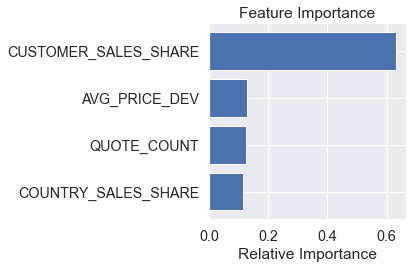

In [39]:
importance = clf_pruned.feature_importances_
indices = np.argsort(importance)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('Thesis/Graphics/feature_importance.svg', format='svg', facecolor=fig.get_facecolor())
plt.show()